In [71]:
import sys
import collections
import gc
import json
import os
import random
import time
import warnings
warnings.simplefilter("ignore")

from albumentations import *
from albumentations.pytorch import ToTensor
import cv2
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tifffile as tiff
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm_notebook as tqdm
from PIL import ImageDraw

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
from loaddata import *
from visualize import *

In [9]:
TRAIN_DATA_PATH = 'train/'

In [194]:
df_merged = load_merged_gps()

In [15]:
#validation splits
# - make sure the same distribution
#  -  locations in validation
#  -  sequences in validation
#  -  distribution of animals

In [195]:
df_merged.to_excel("alldata.xlsx")

In [196]:
# group on location, seq_id
df_location_seq_id = df_merged.groupby(['location', 'seq_id']).size().reset_index(name='freq')
print(len(df_location_seq_id))

36547


In [211]:
# Create a dictionairy with dataframes split by country
def split_by_country(df):
    # this is new stuff, let's split the dataset based on country code. There are only a few countries
    unique_countries = df.CC.unique()
    print(unique_countries)
    df_countries_dict = {country : pd.DataFrame for country in unique_countries}
    for country in df_countries_dict.keys():
        df_countries_dict[country] = df[:][df.CC == country]
    return df_countries_dict
        
df_countries_dict = split_by_country(df_merged)

['EC' 'RW' 'KE' 'BR' 'BZ' 'ZZ' 'GT' 'LA']


In [261]:
df_merged.CC.value_counts()

BZ    85011
ZZ    63291
KE    38537
RW    15997
BR      263
EC      119
GT       88
LA        8
Name: CC, dtype: int64

In [125]:
def species(df_in):
    if not "category_id" in df_in:
        return set()
    return set(pd.unique(df_in["category_id"]))

In [347]:
def split_it(df, split=20):
    df_train = pd.DataFrame()
    df_valid = pd.DataFrame()

    df_sorted = df.sort_values(by=['category_id','seq_id'])
    groups = df.groupby(['category_id','location', 'seq_id'])
    for idx, tmp in tqdm(groups):
        val = random.randint(0, 100)
        s_tmp = species(tmp)
        s_train = species(df_train)
        s_valid = species(df_valid)
        
        if val < int(100-split):
            if s_tmp.issubset(s_train) and not s_tmp.issubset(s_valid):
                df_valid = df_valid.append(tmp)
            else:
                df_train = df_train.append(tmp)
        else:
            if not s_tmp.issubset(s_train):
                df_train = df_train.append(tmp)
            else:
                df_valid = df_valid.append(tmp)
    splits = { "train" : df_train, "valid" : df_valid}
    return splits

In [334]:
splits = split_it(df_merged)

  0%|          | 0/38905 [00:00<?, ?it/s]

In [348]:
splits = split_it(df_countries_dict["LA"])

  0%|          | 0/1 [00:00<?, ?it/s]

In [349]:
# create a set of the species to check if validation covers everything
s_train = species(splits["train"])
s_valid = species(splits["valid"])
for split in splits:
    print(split, len(splits[split]))
#s_test = species(df_test)
print(sorted((s_train) - s_valid))
print(sorted(s_valid - (s_train)))

train 8
valid 0
[144]
[]


In [350]:
# both values should be the same
print(len(s_train))
print(len(s_valid))

1
0


In [351]:
# these are the really hard species
hard_ones = list(s_train - s_valid)
print(len(hard_ones),"species",hard_ones)
df_hard = df_train[df_train["category_id"].isin(hard_ones)]
for h in hard_ones:
    df_hard_specie = df_hard[df_hard["category_id"] == h]
    df_valid = df_valid.append(df_hard_specie)

1 species [144]


In [353]:
images = { split : list(splits[split]["image_id"]) for split in splits}

KeyError: 'image_id'

In [318]:
df_train_boxes = pd.read_csv("_train_clahe_bbox_md3_256x256.csv")

In [319]:
# The box confidence threshold for training
THRESHOLD = 0.85

In [320]:
def split_boxes(df_boxes):
    df_split = {}
    for split in splits:
        df_images_tmp = df_boxes[df_boxes["image_id"].isin(images[split])]
        df_split[split] = df_images_tmp[df_images_tmp["confidence"] > THRESHOLD]
    return df_split

df_boxes_split = split_boxes(df_train_boxes)

In [321]:
df_boxes_split["train"].head()

path                              image_id  \
3433   _train_clahe_bbox_md3_256x256  8f672f7e-21bc-11ea-a13a-137349068a90   
3434   _train_clahe_bbox_md3_256x256  8f672f7e-21bc-11ea-a13a-137349068a90   
5949   _train_clahe_bbox_md3_256x256  96243000-21bc-11ea-a13a-137349068a90   
10485  _train_clahe_bbox_md3_256x256  90e299f6-21bc-11ea-a13a-137349068a90   
11631  _train_clahe_bbox_md3_256x256  90fad002-21bc-11ea-a13a-137349068a90   

       idx                                           filename  confidence  \
3433     1  _train_clahe_bbox_md3_256x256/8f672f7e-21bc-11...       1.000   
3434     2  _train_clahe_bbox_md3_256x256/8f672f7e-21bc-11...       1.000   
5949     1  _train_clahe_bbox_md3_256x256/96243000-21bc-11...       0.998   
10485    1  _train_clahe_bbox_md3_256x256/90e299f6-21bc-11...       0.999   
11631    1  _train_clahe_bbox_md3_256x256/90fad002-21bc-11...       1.000   

       category_id  
3433           378  
3434           378  
5949           372  
10485          372  
11631          372

In [322]:
df_boxes_split["train"].to_csv("train_split_GT_md3_256_80.csv")
df_boxes_split["valid"].to_csv("valid_split_GT_md3_256_20.csv")

In [ ]:
additional_files = ["_inaturalist_clahe_bbox_2017_md4_256x256.csv",
                    "_inaturalist_clahe_bbox_2018_md4_256x256.csv"]

In [180]:
# load some additional files
files = ["_inaturalist_clahe_bbox_2017_md4_256x256.csv", "_inaturalist_clahe_bbox_2018_md4_256x256.csv"]
for f in files:
    df_train_split.append(pd.read_csv(f))

In [181]:
df_train_split.to_csv("train_split.csv")

In [182]:
df_valid_split.to_csv("valid_split.csv")

In [65]:
seq = "302ad820-7d42-11eb-8fb5-0242ac1c0002"

In [52]:
def visualize_category(catid):
    annos = df_anno[df_anno["category_id"] == catid]
    boxes = pd.merge(annos, df_dets, on="image_id")
    # skip the annotations with empty detections
    boxes = boxes[boxes.astype(str)['detections'] != "[]"]
    #print(boxes.head())
    size = (480,270)
    fig = plt.figure(figsize=(25, 16))
    for i, (idx,ann) in enumerate(boxes.sample(frac=1).head(12).iterrows()):
        im_path = TRAIN_DATA_PATH+ann["image_id"]+'.jpg'
        ax = fig.add_subplot(4, 3, i+1, xticks=[], yticks=[])
        draw_image(im_path, size, ann)

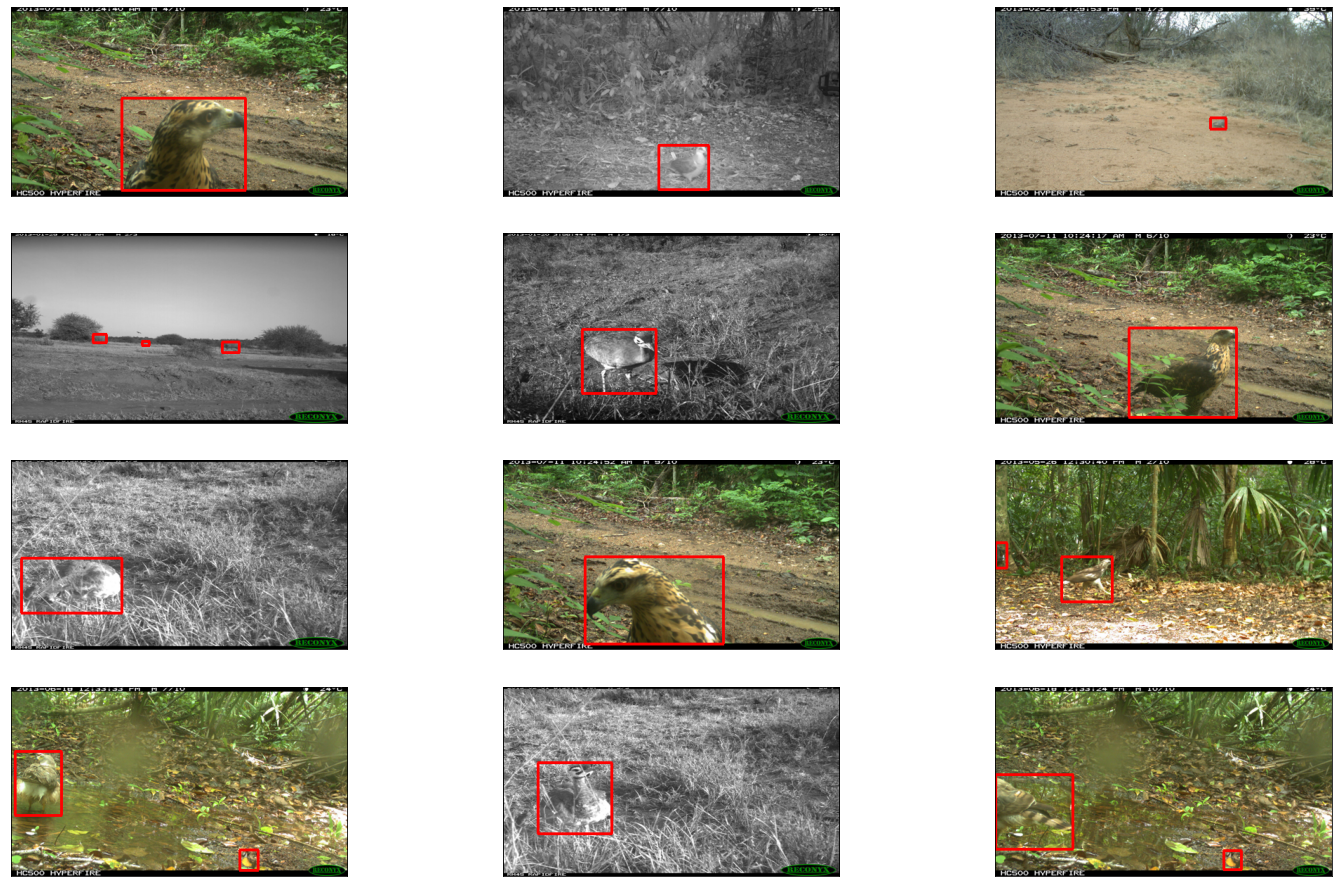

In [63]:
#visualize_category(558)
visualize_category(177)

In [68]:
seq = "3001cbf6-7d42-11eb-8fb5-0242ac1c0002" # zebra and giraffe

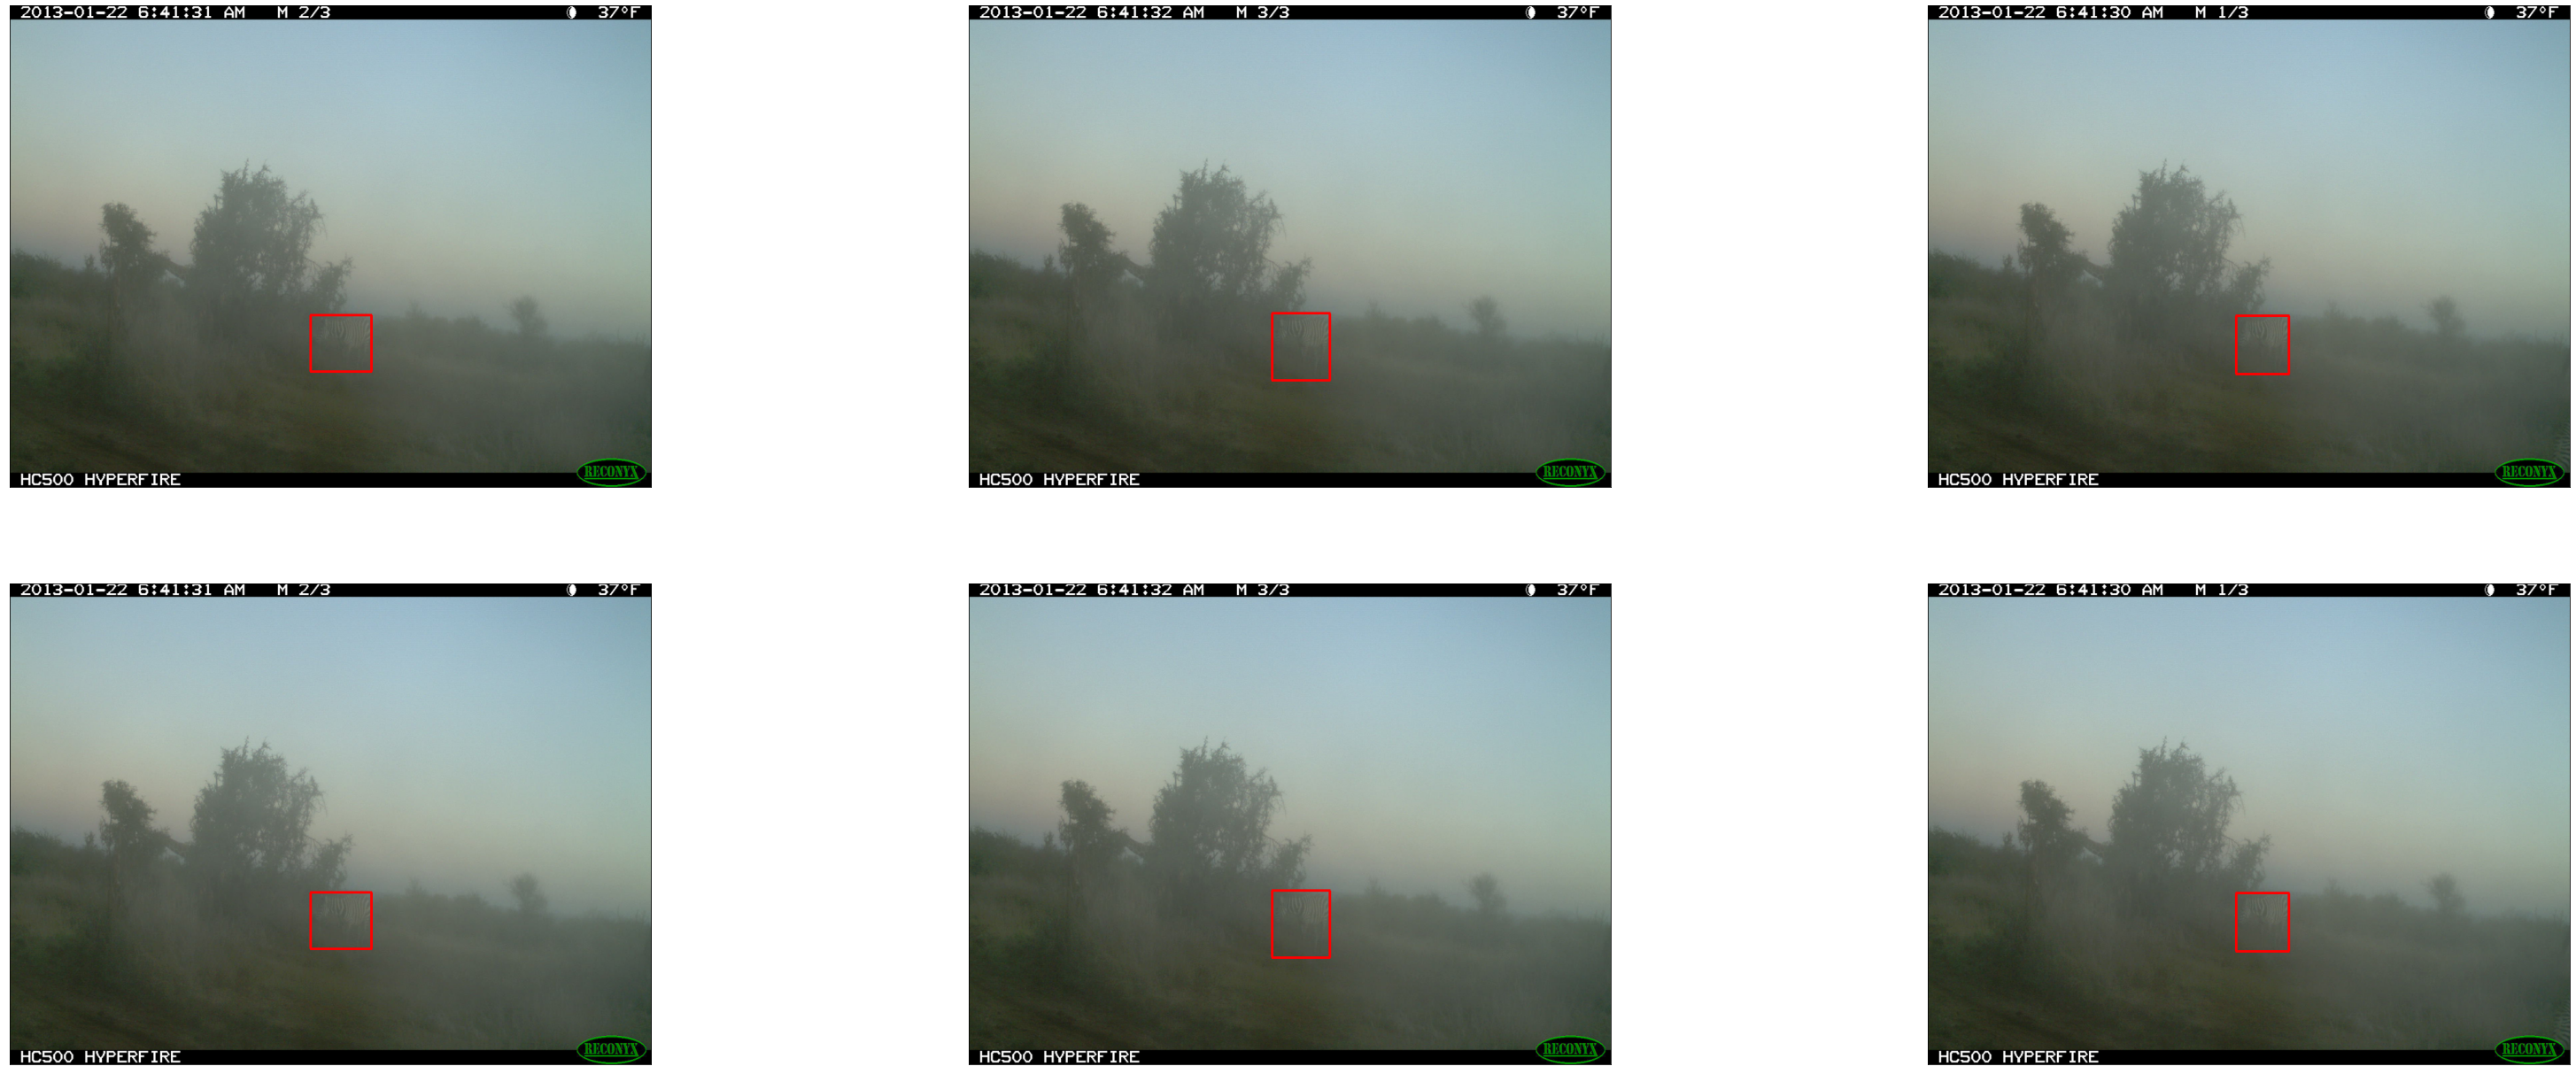

In [72]:
visualize_sequence(seq)